In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from lsmcmc import algorithms, logging, model, output, sampling, storage

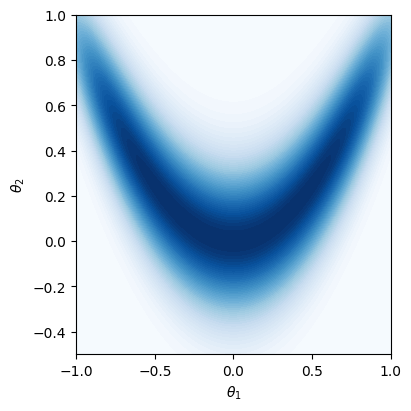

In [2]:
def evaluate_density(x_value, y_value):
    logp = 10 * np.square(np.square(x_value) - y_value) + np.power(y_value, 4)
    probability = np.exp(-logp)
    return probability


def plot_density(x_value, y_value, density):
    _, ax = plt.subplots(figsize=(4, 4), layout="constrained")
    ax.contourf(x_value, y_value, density, cmap="Blues", levels=50)
    ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$")
    plt.show()


x_value = np.linspace(-1, 1, 1000)
y_value = np.linspace(-0.5, 1, 1000)
x_value, y_value = np.meshgrid(x_value, y_value)

density = evaluate_density(x_value, y_value)
plot_density(x_value, y_value, density)

In [3]:
class BananaModel(model.MCMCModel):
    def __init__(self):
        self._reference_point = np.array([0.0, 0.0])
        self._preconditioner_sqrt_matrix = np.identity(2)

    @staticmethod
    def evaluate_potential(state):
        potential = (
            10 * np.square(np.square(state[0]) - state[1])
            + np.power(state[1], 4)
            - 0.5 * (np.square(state[0]) + np.square(state[1]))
        )
        return potential

    def compute_preconditioner_sqrt_action(self, state):
        action = self._preconditioner_sqrt_matrix @ state
        return action

    @property
    def reference_point(self):
        return self._reference_point

In [4]:
acceptance_rate_output = output.MCMCOutput(
    output.AcceptanceQoI(), output.RunningMeanStatistic(), f"{'Accept Rate':<12}", "<+12.3e", log=True
)
mean_c0_output = output.MCMCOutput(
    output.ComponentQoI(0), output.IdentityStatistic(), f"{'Component 0':<12}", "<+12.3e", log=True
)
running_mean_c0_output = output.MCMCOutput(
    output.ComponentQoI(0), output.RunningMeanStatistic(), f"{'Run_mean_C0':<12}", "<+12.3e", log=True
)
batch_mean_c0_output = output.MCMCOutput(
    output.ComponentQoI(0), output.BatchMeanStatistic(1000), f"{'Batch_mean_C0':<14}", "<+14.3e", log=True
)
outputs = (acceptance_rate_output, mean_c0_output, running_mean_c0_output, batch_mean_c0_output)

In [5]:
logger_settings = logging.LoggerSettings(
    do_printing=True,
    logfile_path=Path("logfile.log"),
    write_mode="w",
)
algorithm_settings = algorithms.AlgorithmSettings(
    step_width=0.4,
    proposal_rng=np.random.default_rng(seed=0),
    accept_reject_rng=np.random.default_rng(seed=1),
)
sampler_settings = sampling.SamplerRunSettings(
    num_samples=10000,
    initial_state=np.array([-0.5, 0.2]),
    print_interval=1000,
    store_interval=1,
)

sample_storage = storage.NumpyStorage()
model = BananaModel()
logger = logging.MCMCLogger(logger_settings)
algorithm = algorithms.pCNAlgorithm(algorithm_settings, model)
sampler = sampling.Sampler(algorithm, sample_storage, outputs, logger)
samples, outputs = sampler.run(sampler_settings)

| Iteration   | Time        | Accept Rate | Component 0 | Run_mean_C0 | Batch_mean_C0 | 
---------------------------------------------------------------------------------------
| 0.000e+00   | 1.700e-03   | +1.000e+00  | -5.000e-01  | -5.000e-01  | +0.000e+00    | 
| 1.000e+03   | 5.360e-02   | +4.146e-01  | +9.591e-01  | +3.425e-02  | +3.332e-02    | 
| 2.000e+03   | 7.715e-02   | +4.128e-01  | +6.804e-02  | +4.202e-02  | +5.069e-02    | 
| 3.000e+03   | 1.063e-01   | +4.085e-01  | +4.304e-01  | +9.365e-02  | +1.966e-01    | 
| 4.000e+03   | 1.466e-01   | +4.061e-01  | +8.364e-01  | +1.081e-01  | +1.512e-01    | 
| 5.000e+03   | 1.675e-01   | +4.117e-01  | -7.246e-01  | +1.009e-01  | +7.333e-02    | 
| 6.000e+03   | 1.902e-01   | +4.144e-01  | -6.895e-01  | +8.588e-02  | +1.094e-02    | 
| 7.000e+03   | 2.142e-01   | +4.152e-01  | +5.733e-03  | +8.621e-02  | +8.746e-02    | 
| 8.000e+03   | 2.365e-01   | +4.182e-01  | +5.696e-01  | +8.206e-02  | +5.248e-02    | 
| 9.000e+03   | 2.599e

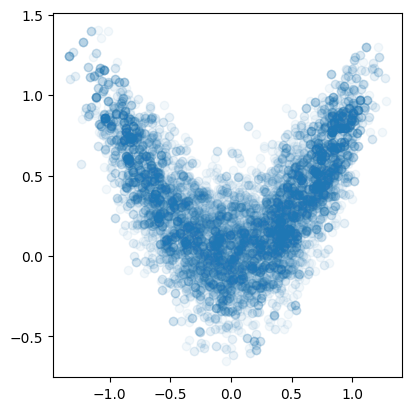

In [6]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.scatter(samples.values[0, :], samples.values[1, :], alpha=0.05)